In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv("NFL Play by Play 2009-2018 (v5).csv")

/var/folders/q0/2htxwbl92pv_k6v0p021gqvm0000gn/T/ipykernel_64583/825731713.py:1: DtypeWarning: Columns (42,166,167,168,169,174,175,178,179,182,183,188,189,190,191,194,195,203,204,205,218,219,220,231,232,233,238,240,241,249) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("NFL Play by Play 2009-2018 (v5).csv")


In [3]:
df.head(5)

,play_id,game_id,home_team,away_team,posteam,posteam_type,defteam,side_of_field,yardline_100,game_date,...,penalty_player_id,penalty_player_name,penalty_yards,replay_or_challenge,replay_or_challenge_result,penalty_type,defensive_two_point_attempt,defensive_two_point_conv,defensive_extra_point_attempt,defensive_extra_point_conv
0,46,2009091000,PIT,TEN,PIT,home,TEN,TEN,30.0,2009-09-10,...,NaN,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0
1,68,2009091000,PIT,TEN,PIT,home,TEN,PIT,58.0,2009-09-10,...,NaN,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0
2,92,2009091000,PIT,TEN,PIT,home,TEN,PIT,53.0,2009-09-10,...,NaN,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0
3,113,2009091000,PIT,TEN,PIT,home,TEN,PIT,56.0,2009-09-10,...,NaN,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0
4,139,2009091000,PIT,TEN,PIT,home,TEN,PIT,56.0,2009-09-10,...,NaN,NaN,NaN,0,NaN,NaN,0.0,0.0,0.0,0.0


In [4]:
pass_df = df[df['play_type'] == 'pass']

input_features = pass_df[['quarter_seconds_remaining', 'down', 'ydstogo', 'yardline_100', 
                     'pass_length', 'pass_location', 'air_yards', 'yards_after_catch', 
                     'score_differential', 'qb_scramble', 'shotgun', 'no_huddle',
                     'comp_air_epa', 'comp_yac_epa']]

target_features = pass_df['pass_touchdown']

input_features = input_features.dropna()
target_features = target_features.loc[input_features.index]

input_features.head()

,quarter_seconds_remaining,down,ydstogo,yardline_100,pass_length,pass_location,air_yards,yards_after_catch,score_differential,qb_scramble,shotgun,no_huddle,comp_air_epa,comp_yac_epa
1,893.0,1.0,10,58.0,short,left,-3.0,8.0,0.0,0,0,0,-0.938735,1.016643
6,760.0,2.0,10,98.0,short,left,3.0,1.0,0.0,0,0,0,-0.521641,0.342492
9,684.0,1.0,10,43.0,short,right,-2.0,5.0,0.0,0,0,0,-0.680790,0.465497
10,648.0,2.0,7,40.0,short,left,-1.0,11.0,0.0,0,0,0,-0.877942,1.740365
12,583.0,2.0,11,31.0,short,right,-2.0,11.0,0.0,0,0,0,-0.906339,1.156385


In [5]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

categorical_cols = ['pass_length', 'pass_location']
numeric_cols = [col for col in input_features if col not in categorical_cols]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(drop='first'), categorical_cols)
    ]
)

input_features = preprocessor.fit_transform(input_features)

In [6]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
X_train, X_test, y_train, y_test = train_test_split(input_features, target_features, test_size=0.2, random_state=513)

In [8]:
import xgboost as xgb

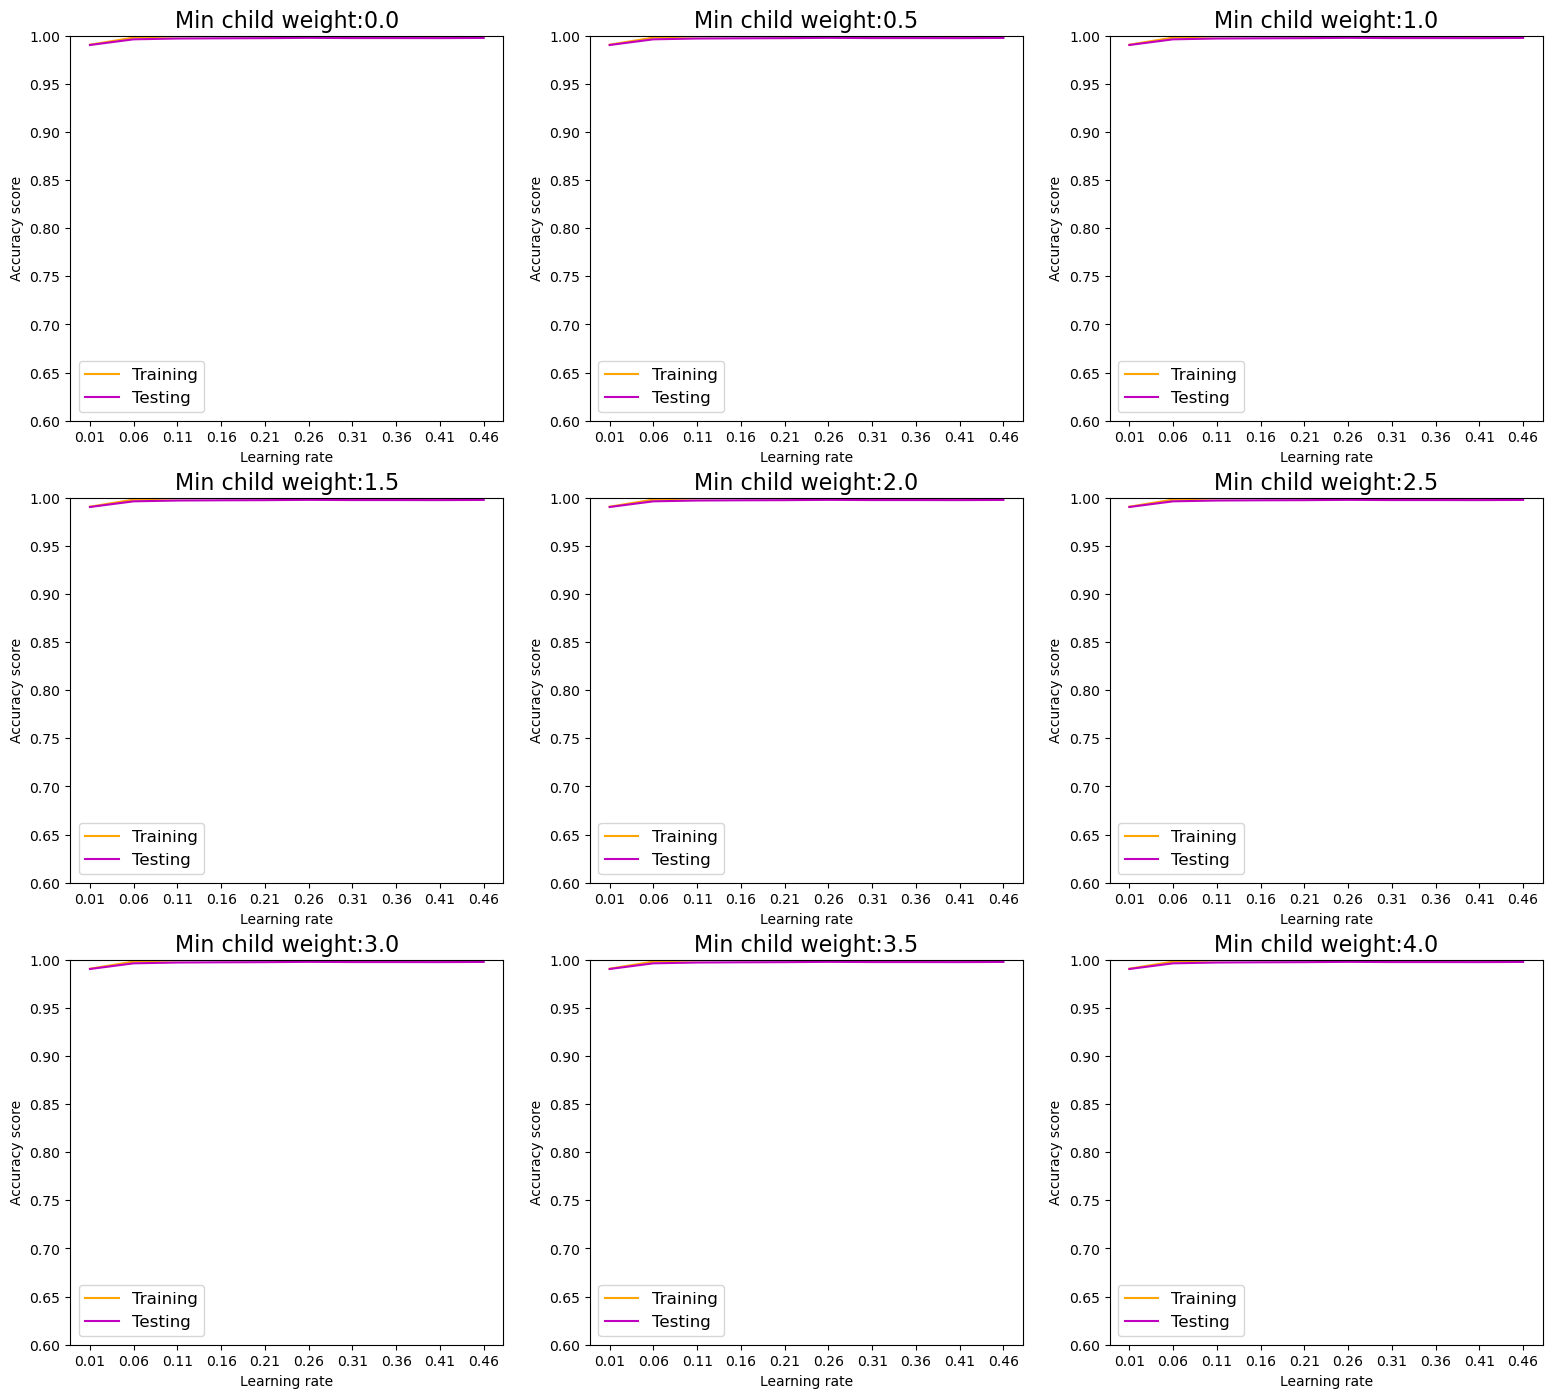

In [9]:
lr_range = np.arange(0.01, 0.5, 0.05)
fig = plt.figure(figsize=(19, 17))
idx = 1
for weight in np.arange(0, 4.5, 0.5):
    train_scores = []
    test_scores = []
    for lr in lr_range:
        xgb_classifier = xgb.XGBClassifier(eta = lr)
        xgb_classifier.fit(X_train, y_train)
        train_scores.append(xgb_classifier.score(X_train, y_train))
        test_scores.append(xgb_classifier.score(X_test, y_test))
    fig.add_subplot(3, 3, idx)
    idx += 1
    plt.plot(lr_range, train_scores, c='orange', label='Training')
    plt.plot(lr_range, test_scores, c='m', label='Testing')
    plt.xlabel('Learning rate')
    plt.xticks(lr_range)
    plt.ylabel('Accuracy score')
    plt.ylim(0.6, 1)
    plt.legend(prop={'size': 12}, loc=3)
    title = "Min child weight:" + str(weight)
    plt.title(title, size=16)
plt.show()

In [10]:
final_model = xgb.XGBClassifier(eta = 0.11, min_child_weight = 3.5)
final_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eta=0.11, eval_metric=None,
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=3.5, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None, ...)

In [11]:
y_pred = final_model.predict(X_test)

In [12]:
from sklearn.metrics import accuracy_score, classification_report

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.9969564214895089
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     20160
         1.0       0.96      0.99      0.98      1525

    accuracy                           1.00     21685
   macro avg       0.98      1.00      0.99     21685
weighted avg       1.00      1.00      1.00     21685



In [13]:
new_data = {
    'quarter_seconds_remaining': [893.0],
    'down': [1.0],
    'ydstogo': [10],
    'yardline_100': [13.0],
    'pass_length': ['short'],
    'pass_location': ['left'],
    'air_yards': [15.0],
    'yards_after_catch': [0.0],
    'score_differential': [0.0],
    'qb_scramble': [0],
    'shotgun': [0],
    'no_huddle': [0],
    'comp_air_epa': [4.5212],
    'comp_yac_epa': [0]
}

X_new = pd.DataFrame(new_data)

In [14]:
X_new = preprocessor.transform(X_new)
print(X_new)

[[ 1.7208005  -1.08565068  0.23848739 -1.75485614  1.03458217 -0.72217998
   0.25829353 -0.00803538 -1.51772987 -0.34271601  3.31018849 -0.6001595
   1.          0.          0.        ]]


In [15]:
prediction = final_model.predict(X_new)

In [16]:
print(prediction)

[1]
